# Disease Classification
##### A Data Scientist Captone Project

### Extract, Transform and Load
In this script, I extract, transform and load (ETL) data that comprises of 42 diseases each defined by its respective set of symptoms taken from 132 possibilities. This data is sourced from https://www.kaggle.com/datasets/marslinoedward/disease-prediction-data (Edward, M. (Owner). (2024, Jan)).

Below is a table of contents giving the structure of the ETL process and how it is carried out.

### Table of Contents

I.      [Import Libraries](#i-import-libraries)<br>
II.     [Source Original Data](#ii-source-original-data)<br>
III.    [Clean Data](#iii-clean-data)<br>
IV.     [Exploratory Data Analysis (a)](#iv-exploratory-data-analysis-a)<br>
V.      [Transform Data](#v-transform-data)<br>
VI.     [Exploratory Data Analysis (b)](#vi-exploratory-data-analysis-b)<br>
IV.     [Finalize Data](#vii-finalize-data)<br>

### <a class="anchor" id="i-import-libraries">I: Import Libraries</a>

In [52]:
# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tabulate

### <a class="anchor" id="ii-source-original-data">II: Source Original Data</a>

In [53]:
# Import training and test data
train_data = pd.read_csv("Training.csv")
test_data = pd.read_csv("Testing.csv")

# Identify repeated column names in the training data
train_data.columns = train_data.columns.str.replace(r"\.\d+$", "", regex=True)

# Identify repeated column names in the testing data
test_data.columns = test_data.columns.str.replace(r"\.\d+$", "", regex=True)

### <a class="anchor" id="iii-clean-data">III: Clean Data</a>

In [54]:
# Remove unnamed column from training data
train_data.drop(columns=['Unnamed: 133'], inplace=True)

# Row-bind training and testing data
d_data = pd.concat([train_data, test_data])

# Append a row index column
d_data['row_index'] = range(1, len(d_data) + 1)

# Split data to a 80/20 new training and testing samples
new_train_data, new_test_data = train_test_split(d_data, test_size=0.2, random_state=42)

# Save clean test data for later
new_test_data.to_csv("Clean_Disease_Testing_Data.csv", index=False)

### <a class="anchor" id="iv-exploratory-data-analysis-a">IV: Exploratory Data Analysis (a)</a>

C:\Users\brian.meki\AppData\Local\Temp\ipykernel_18884\190960255.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(disease_freq_distr_raw['Disease'], rotation=90)


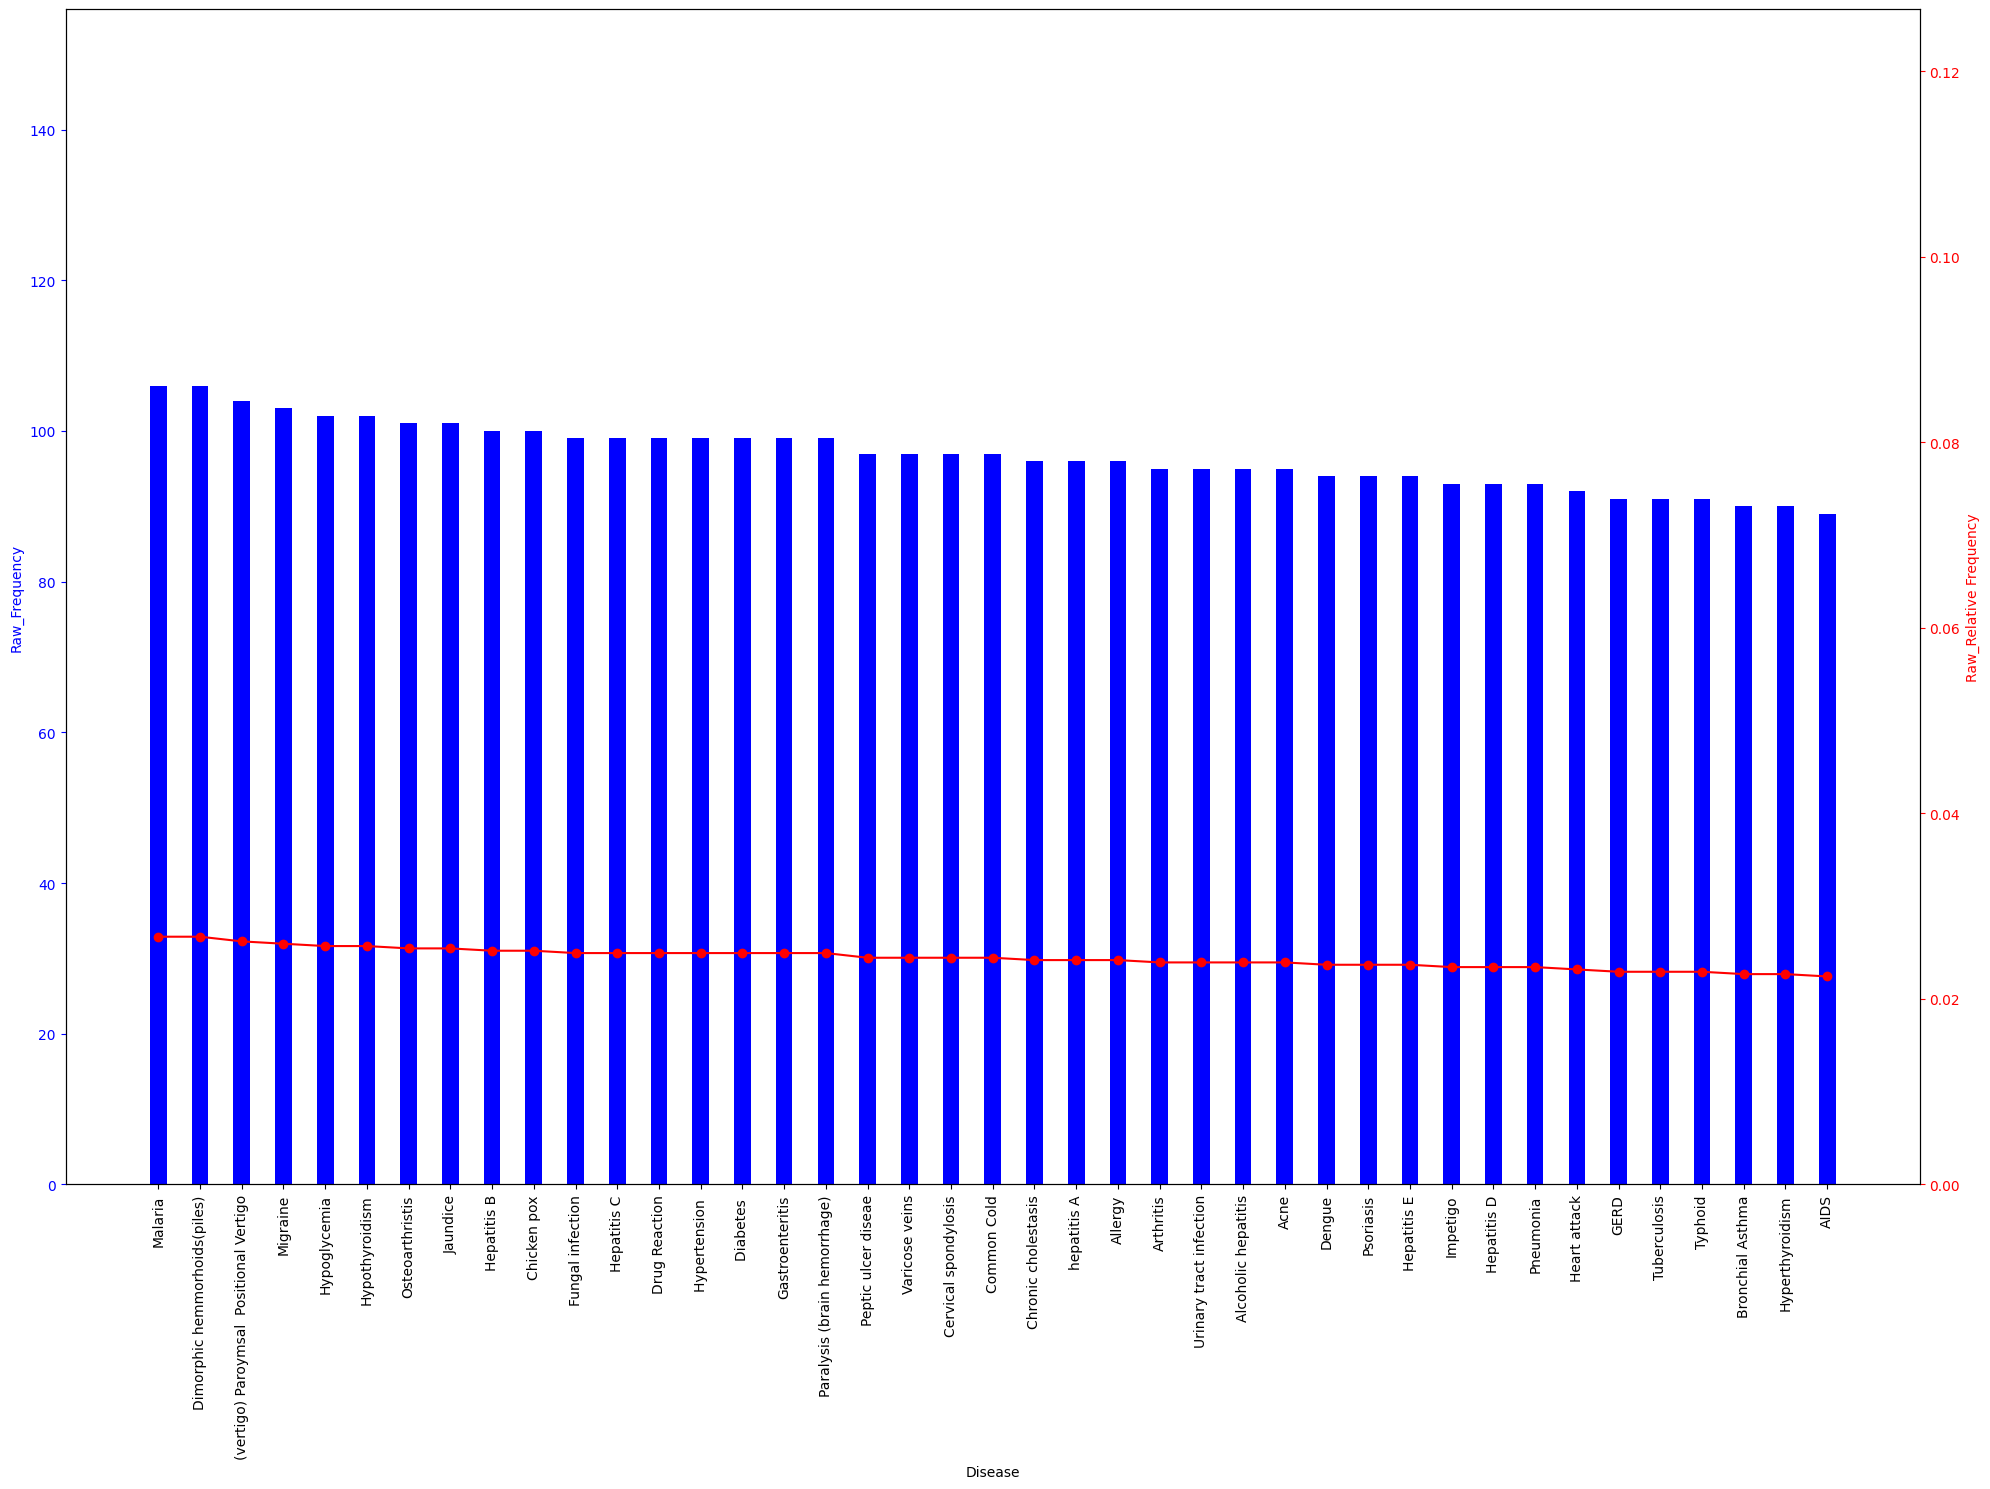

C:\Users\brian.meki\AppData\Local\Temp\ipykernel_18884\190960255.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 2000x1500 with 0 Axes>

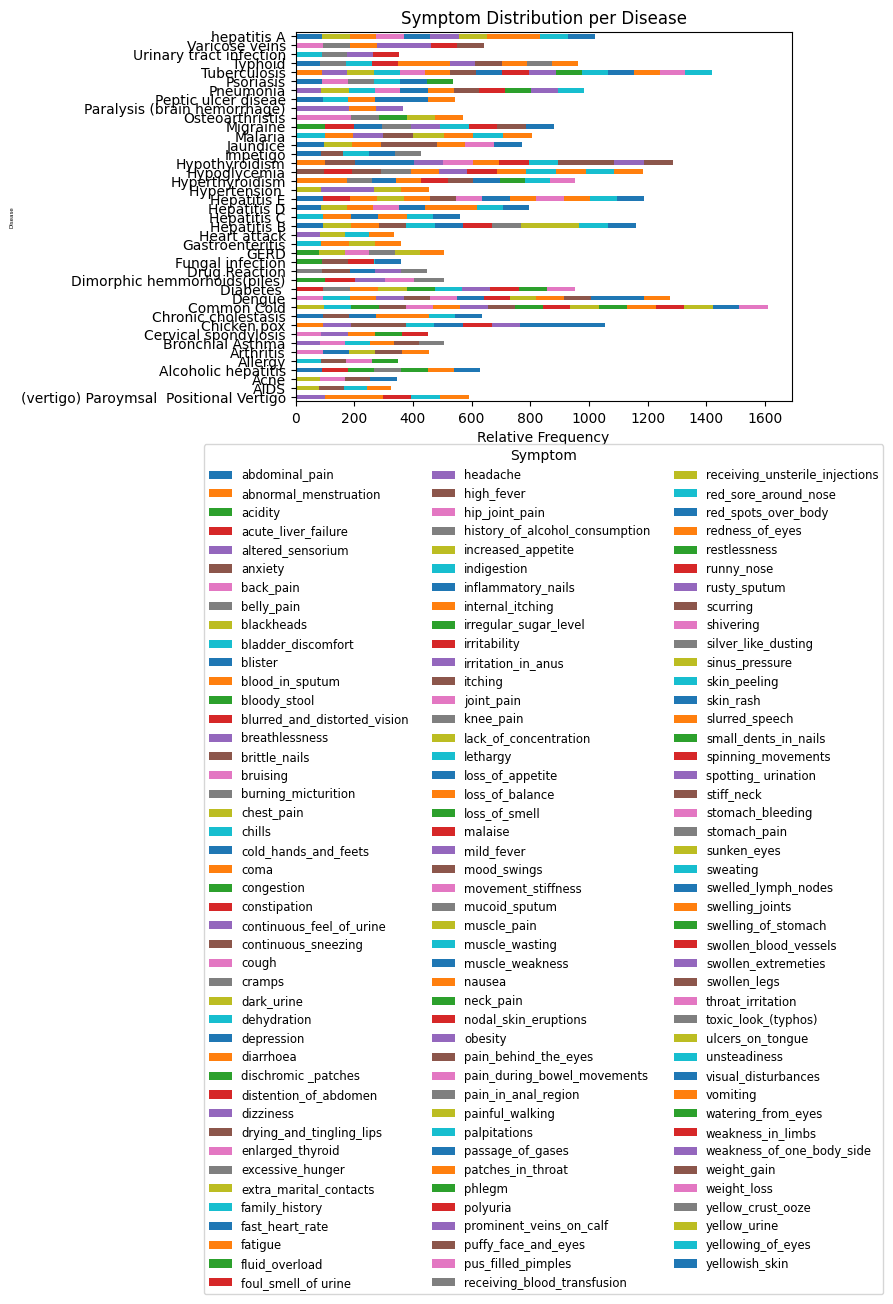

In [55]:
# Analyze training sample
bin_data_fin = new_train_data.drop(columns=['row_index'])

# Extract binary distribution for each disease
bin_vars = bin_data_fin['prognosis'].unique()
fin_df = pd.DataFrame()
for d in bin_vars:
    bin_mat = bin_data_fin[bin_data_fin['prognosis'] == d].drop(columns=['prognosis']).sum()
    bin_mat = bin_mat[bin_mat > 0]
    bin_df = pd.DataFrame(bin_mat).T
    bin_df.columns = bin_mat.index
    long_form = bin_df.melt(var_name='Symptom', value_name='Frequency')
    long_form['Disease'] = d
    fin_df = pd.concat([fin_df, long_form], ignore_index=True)
    
# Check symptom presence variability
fin_df['Relative_Frequency'] = fin_df.groupby('Disease')['Frequency'].transform(lambda x: x / x.sum())
grouped_diseases = pd.DataFrame({'Disease': fin_df['Disease'].unique()})

fin_df = fin_df.merge(grouped_diseases, on='Disease')

# Plot frequency distributions
disease_freq_distr_raw = bin_data_fin['prognosis'].value_counts().reset_index()
disease_freq_distr_raw = pd.DataFrame(disease_freq_distr_raw)
disease_freq_distr_raw.columns = ['Disease', 'Raw_Frequency']
disease_freq_distr_raw['Raw_Relative_Frequency'] = disease_freq_distr_raw['Raw_Frequency'] / disease_freq_distr_raw['Raw_Frequency'].sum()

# Summarise relative frequencies
summary_df0 = disease_freq_distr_raw['Raw_Relative_Frequency'].describe()
summary_df0 = pd.DataFrame(summary_df0)
summary_df0.reset_index(inplace=True)
summary_df0.columns = ['Statistic', 'Original']

# Set the figure size
fig, ax1 = plt.subplots(figsize=(20, 15))

# Bar plot
bar_width = 0.4  # Adjust the width of the bars as needed
ax1.bar(disease_freq_distr_raw['Disease'], disease_freq_distr_raw['Raw_Frequency'], color='b', width=bar_width)
ax1.set_xlabel('Disease')
ax1.set_ylabel('Raw_Frequency', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(0, disease_freq_distr_raw['Raw_Frequency'].max() + 50)  # Adjust the padding (e.g., +50) as needed
ax1.set_xticklabels(disease_freq_distr_raw['Disease'], rotation=90)

# Line graph
ax2 = ax1.twinx()
ax2.plot(disease_freq_distr_raw['Disease'], disease_freq_distr_raw['Raw_Relative_Frequency'], color='r', marker='o')
ax2.set_ylabel('Raw_Relative Frequency', color='r')
ax2.tick_params('y', colors='r')
ax2.set_ylim(0, disease_freq_distr_raw['Raw_Relative_Frequency'].max() + 0.1)  # Adjust the padding (e.g., +0.1) as needed
plt.tight_layout()
plt.savefig("Disease_Distribution.png")
plt.show()

# Plot symptom distribution per disease (stacked bar graph)
plt.figure(figsize=(20, 15))
fin_df.pivot_table(index='Disease', columns='Symptom', values='Frequency', aggfunc='sum').plot(kind='barh', stacked=True, legend=True)
plt.xlabel('Relative Frequency', fontsize=10)
plt.ylabel('Disease', fontsize=4)
plt.title('Symptom Distribution per Disease')
plt.legend(title='Symptom', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, fontsize='small')
plt.tight_layout()
plt.savefig("Symptom_Distribution_per_Disease.png")
plt.show()

### <a class="anchor" id="v-transform-data">V: Transform Data</a>

In [56]:
# Add noise to the data
new_train_data.reset_index(drop=True, inplace=True)

# Simulate client inconsistency
noise_factor = .5
N = len(new_train_data)
tmp_vec = list(range(N))
random.shuffle(tmp_vec)
client_sample = new_train_data.sample(frac=noise_factor)
client_sample_X = client_sample.drop(columns=['prognosis', 'row_index'])
col_row_index_df = pd.DataFrame({
    'row': np.random.choice(client_sample_X.index, size=client_sample_X.shape[0]),
    'col': np.random.choice(client_sample_X.columns, size=client_sample_X.shape[0]),
    'rand_bit': np.random.choice([0, 1], size=client_sample_X.shape[0])
})

# Add noise to patient symptoms
for i, row in col_row_index_df.iterrows():
    client_sample.at[row['row'], row['col']] = row['rand_bit']

# Add data to training set
new_train_data = new_train_data[~new_train_data['row_index'].isin(client_sample['row_index'])]
new_train_data = pd.concat([new_train_data, client_sample], ignore_index=True)

# Simulate doctor's shortfalls
docs_sample = new_train_data.sample(frac=noise_factor)
docs_sample['prognosis'] = docs_sample['prognosis'].sample(frac=1, replace=True).reset_index(drop=True)

# Add noisy doctor's data to main data frame
new_train_data = new_train_data[~new_train_data['row_index'].isin(docs_sample['row_index'])]
new_train_data = pd.concat([new_train_data, docs_sample], ignore_index=True)

# Clean data
new_train_data.drop(columns=['row_index'], inplace=True)
new_train_data.dropna(inplace=True)

# Save noisy data
new_train_data.to_csv("Noisy_Disease_Training_Data.csv", index=False)

### <a class="anchor" id="vi-exploratory-data-analysis-b">VI: Exploratory Data Analysis (b)</a>

C:\Users\brian.meki\AppData\Local\Temp\ipykernel_18884\558242979.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(disease_freq_distr_new['Disease'], rotation=90)


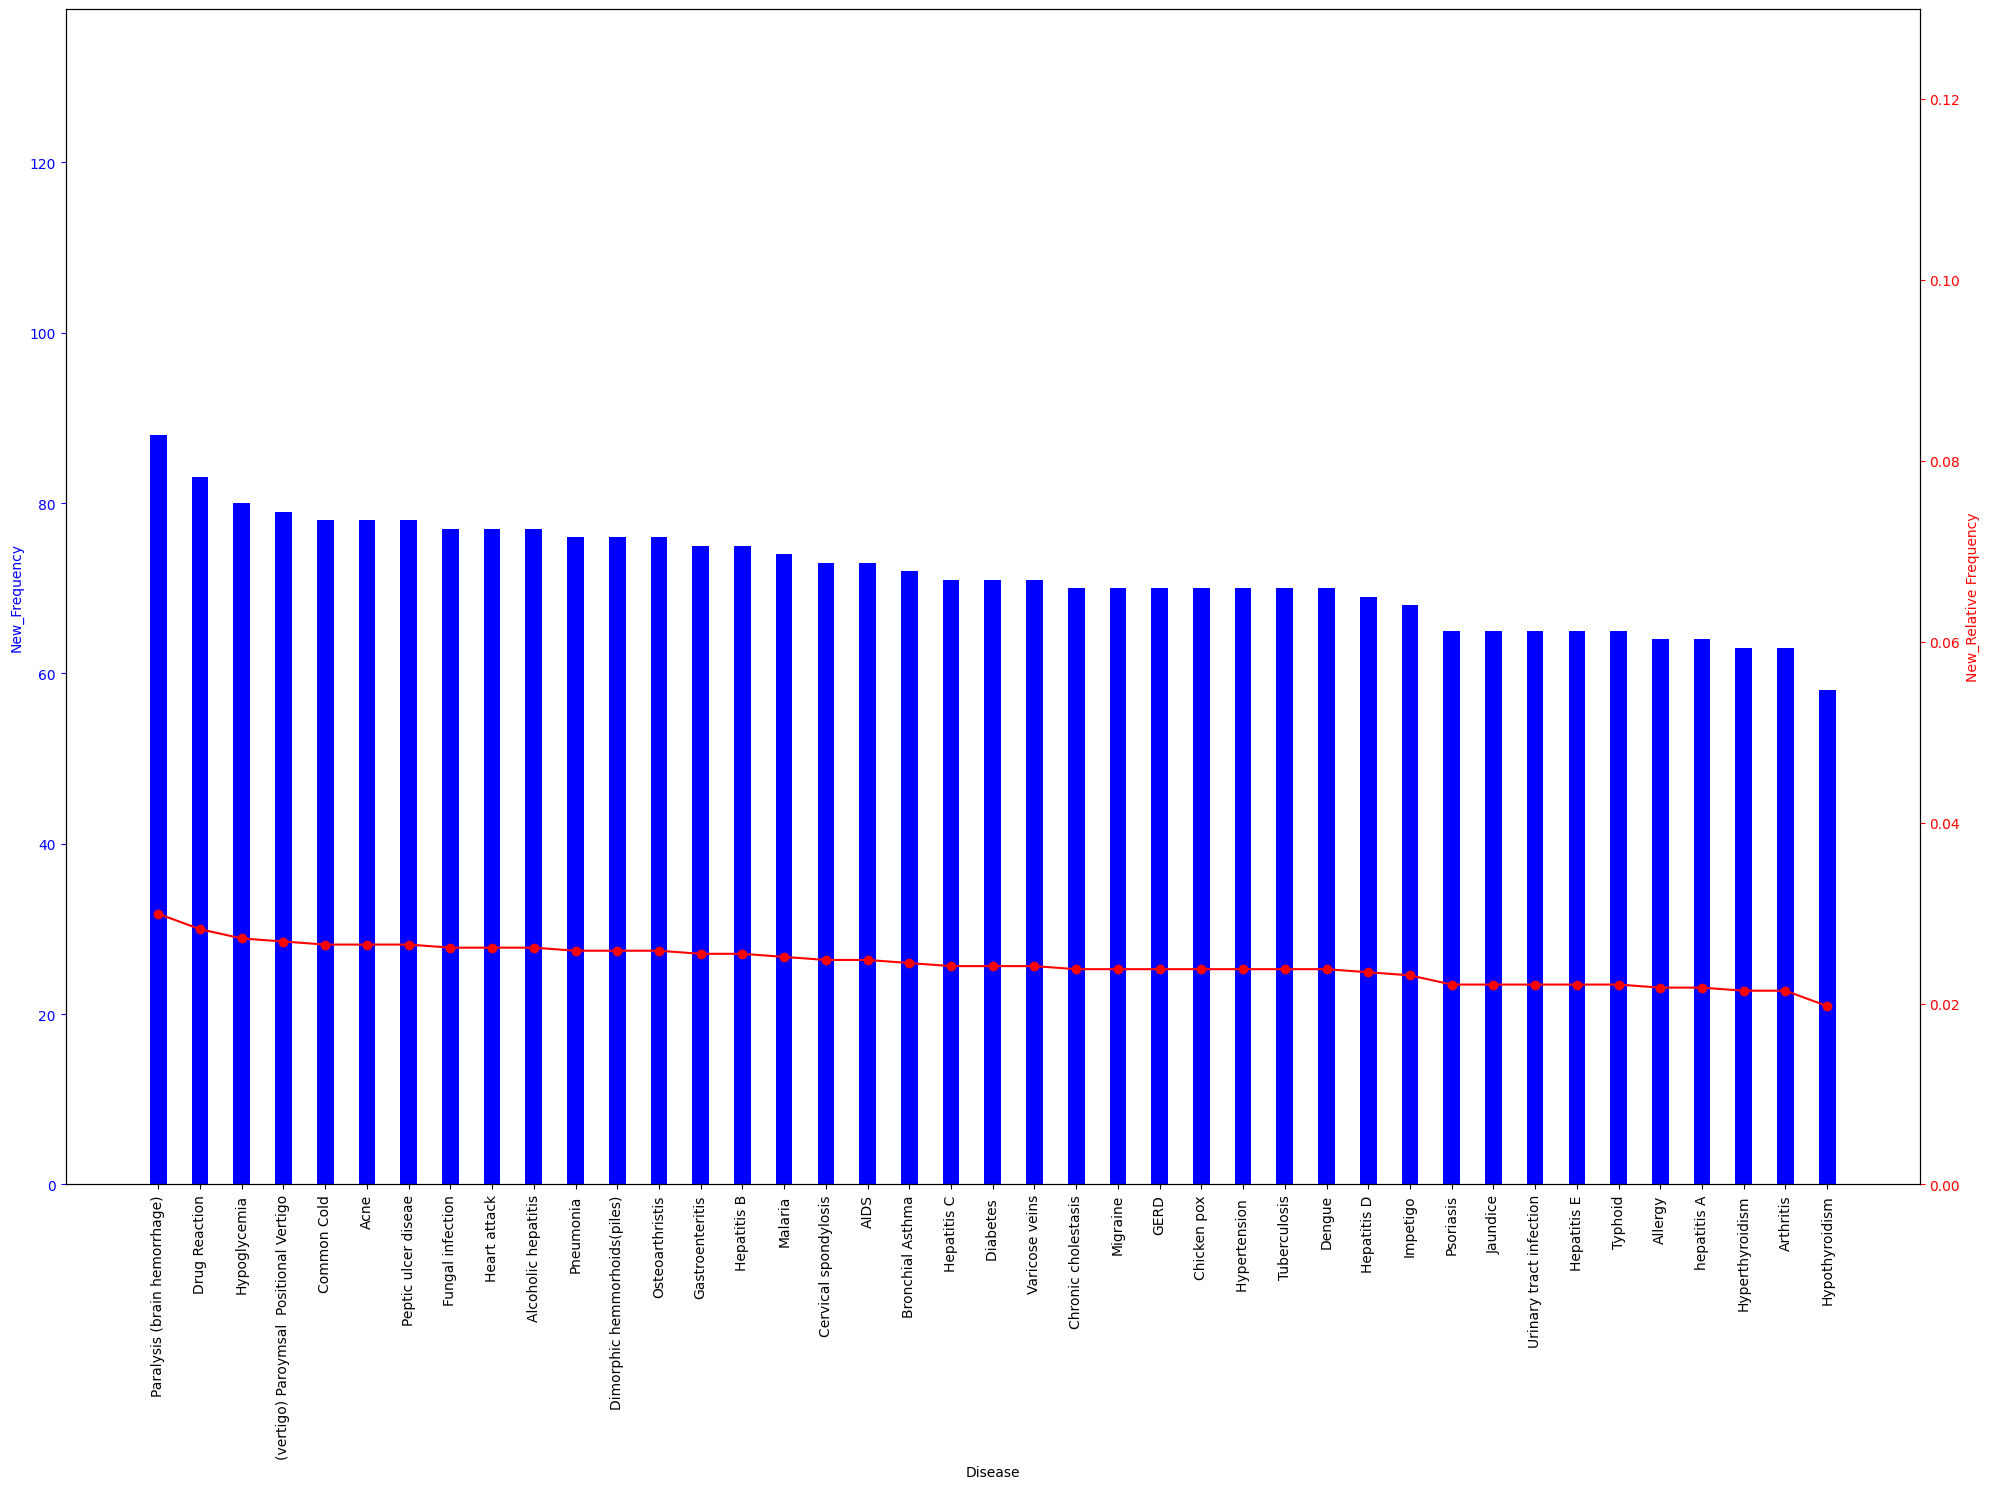

                                    Disease  New_Frequency  \
0              Paralysis (brain hemorrhage)             88   
1                             Drug Reaction             83   
2                              Hypoglycemia             80   
3   (vertigo) Paroymsal  Positional Vertigo             79   
4                               Common Cold             78   
5                                      Acne             78   
6                       Peptic ulcer diseae             78   
7                          Fungal infection             77   
8                              Heart attack             77   
9                       Alcoholic hepatitis             77   
10                                Pneumonia             76   
11             Dimorphic hemmorhoids(piles)             76   
12                          Osteoarthristis             76   
13                          Gastroenteritis             75   
14                              Hepatitis B             75   
15      

C:\Users\brian.meki\AppData\Local\Temp\ipykernel_18884\558242979.py:76: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


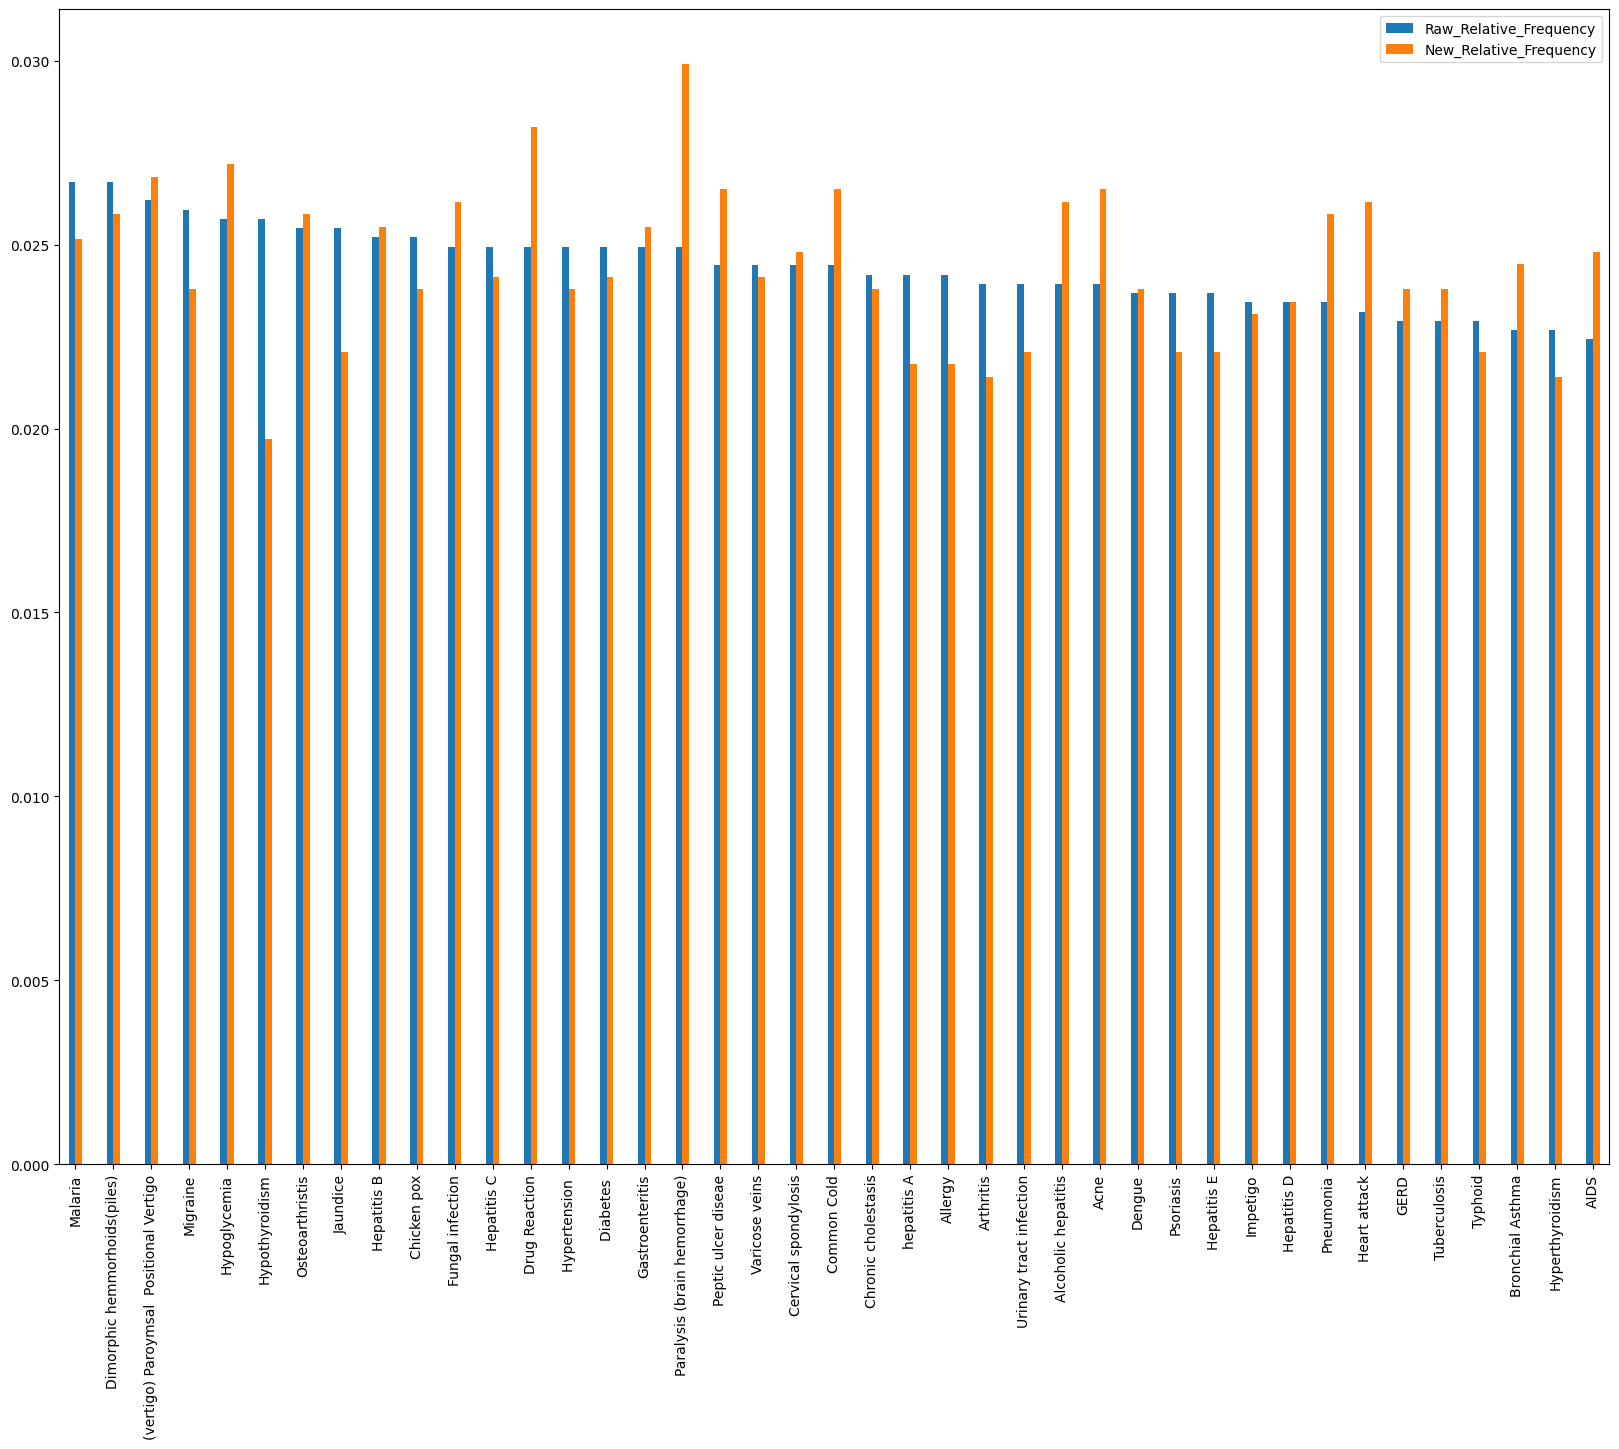

<Figure size 2000x1500 with 0 Axes>

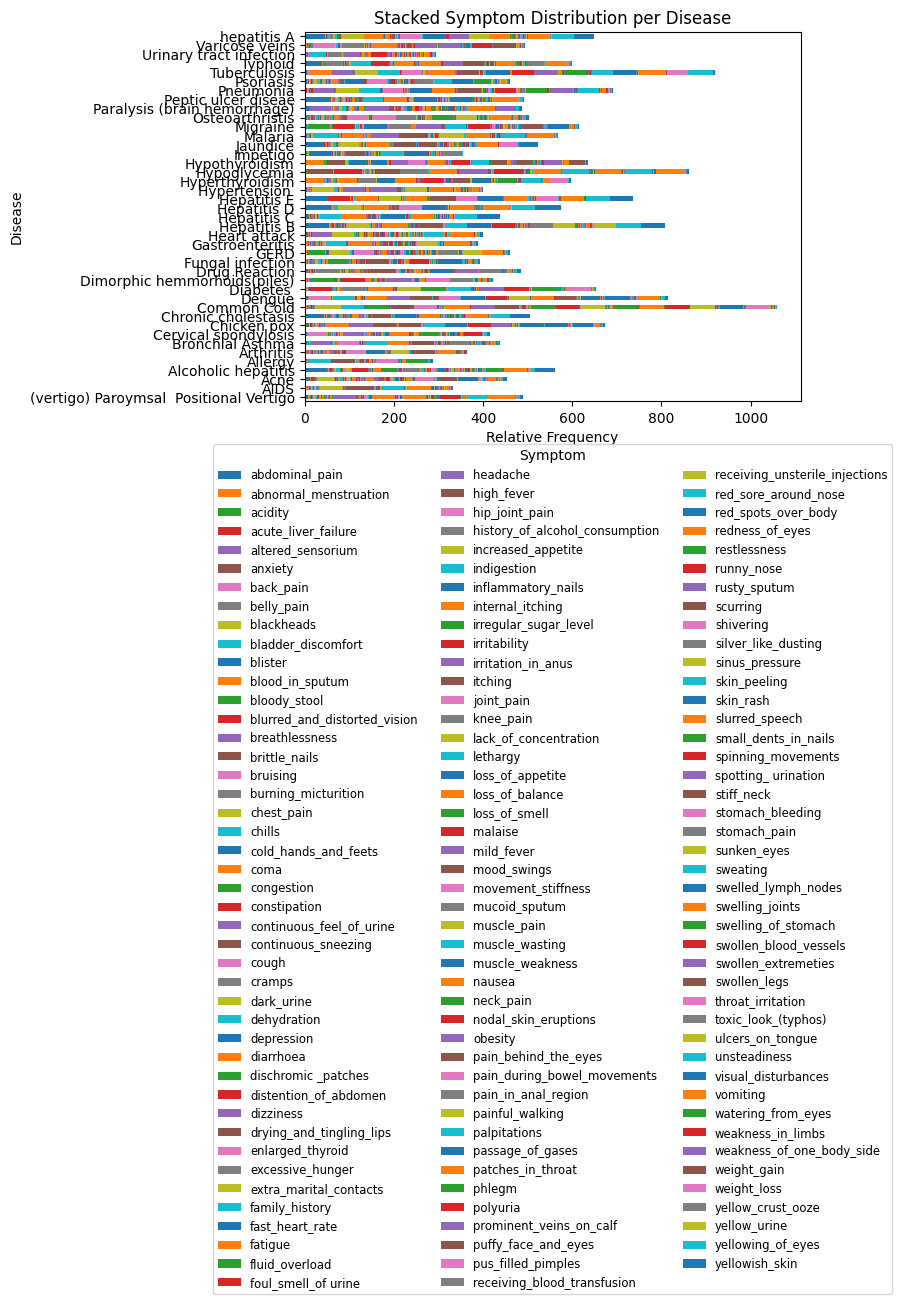

In [61]:
# Plot the new relative frequencies
disease_freq_distr_new = new_train_data['prognosis'].value_counts().reset_index()
disease_freq_distr_new = pd.DataFrame(disease_freq_distr_new)
disease_freq_distr_new.columns = ['Disease', 'New_Frequency']
disease_freq_distr_new['New_Relative_Frequency'] = disease_freq_distr_new['New_Frequency'] / disease_freq_distr_new['New_Frequency'].sum()

# Summarise relative frequencies
summary_df1 = disease_freq_distr_new['New_Relative_Frequency'].describe()
summary_df1 = pd.DataFrame(summary_df1)
summary_df1.reset_index(inplace=True)
summary_df1.columns = ['Statistic', 'Transformed']

# Set the figure size
fig, ax1 = plt.subplots(figsize=(20, 15))

# Bar plot
bar_width = 0.4  # Adjust the width of the bars as needed
ax1.bar(disease_freq_distr_new['Disease'], disease_freq_distr_new['New_Frequency'], color='b', width=bar_width)
ax1.set_xlabel('Disease')
ax1.set_ylabel('New_Frequency', color='b')
ax1.tick_params('y', colors='b')
ax1.set_ylim(0, disease_freq_distr_new['New_Frequency'].max() + 50)  # Adjust the padding (e.g., +50) as needed
ax1.set_xticklabels(disease_freq_distr_new['Disease'], rotation=90)

# Line graph
ax2 = ax1.twinx()
ax2.plot(disease_freq_distr_new['Disease'], disease_freq_distr_new['New_Relative_Frequency'], color='r', marker='o')
ax2.set_ylabel('New_Relative Frequency', color='r')
ax2.tick_params('y', colors='r')
ax2.set_ylim(0, disease_freq_distr_new['New_Relative_Frequency'].max() + 0.1)  # Adjust the padding (e.g., +0.1) as needed
plt.tight_layout()
plt.savefig("New_Disease_Distribution.png")
plt.show()

# Append disease frequency data and plot compare before and after noise addition
raw_new_freq_df = pd.merge(disease_freq_distr_raw, disease_freq_distr_new, on='Disease', how='inner')
raw_new_freq_df[['Raw_Relative_Frequency','New_Relative_Frequency']].plot(kind='bar', width = .35, figsize=(20, 15))
ax = plt.gca()
ax.set_xticklabels(raw_new_freq_df['Disease'])

print(disease_freq_distr_new)

# Save comparative before and after output
plt.savefig("Before_and_After_Noise_Addition.png")

# Analyze new training sample after adding noise to data
bin_data_fin = new_train_data

# Extract binary distribution for each disease
bin_vars = bin_data_fin['prognosis'].unique()
fin_df = pd.DataFrame()
for d in bin_vars:
    bin_mat = bin_data_fin[bin_data_fin['prognosis'] == d].drop(columns=['prognosis']).sum()
    bin_mat = bin_mat[bin_mat > 0]
    bin_df = pd.DataFrame(bin_mat).T
    bin_df.columns = bin_mat.index
    long_form = bin_df.melt(var_name='Symptom', value_name='Frequency')
    long_form['Disease'] = d
    fin_df = pd.concat([fin_df, long_form], ignore_index=True)
    
# Check symptom presence variability
fin_df['Relative_Frequency'] = fin_df.groupby('Disease')['Frequency'].transform(lambda x: x / x.sum())
grouped_diseases = pd.DataFrame({'Disease': fin_df['Disease'].unique()})
fin_df = fin_df.merge(grouped_diseases, on='Disease')

# Save data after adding noise
fin_df.to_csv("Noisy_Summary_of_Training_Data.csv", index=False)

# Plot checks for symptom distribution per disease (stacked bar graph)
plt.figure(figsize=(50, 20))
fin_df.pivot_table(index='Disease', columns='Symptom', values='Frequency', aggfunc='sum').plot(kind='barh', stacked=True)
plt.xlabel('Relative Frequency')
plt.ylabel('Disease')
plt.title('Stacked Symptom Distribution per Disease')
plt.legend(title='Symptom', bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=3, fontsize='small')
plt.tight_layout()
plt.savefig("New_Stacked_Symptom_Distribution_per_Disease.png")
plt.show()


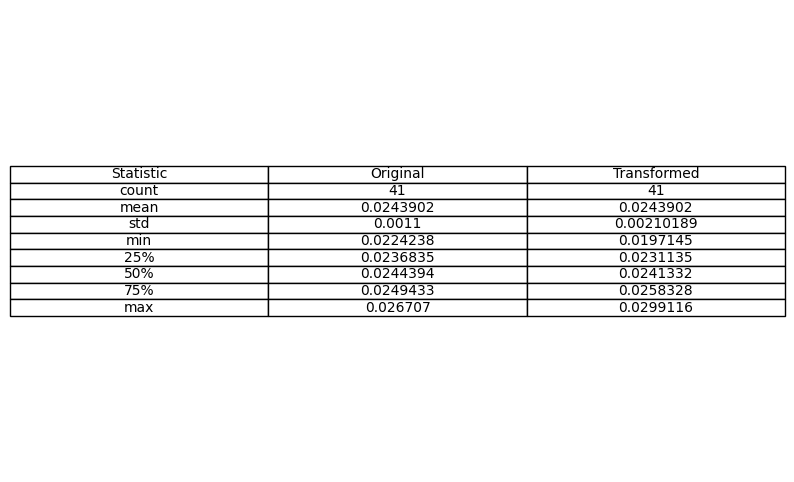

In [58]:
# Compare relative frequencies
compare_freqs = pd.merge(summary_df0, summary_df1, on = 'Statistic')

# Generate the table as a string using tabulate
table_str = tabulate.tabulate(compare_freqs, headers=compare_freqs.columns, tablefmt='plain', showindex=False)

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(10, 6))

# Remove the axes
ax.axis('off')

# Plot the table as text (excluding the first row)
table = ax.table(cellText=[row.split() for row in table_str.split('\n')[1:]], loc='center', cellLoc='center', colLabels=compare_freqs.columns)

# Save the figure as a PNG file
plt.savefig('compare_summary_stats.png', bbox_inches='tight', pad_inches=0.1)




### <a class="anchor" id="vii-finalize-data">VII: Finalize Data</a>

In [64]:
# Check for and remove missing values
new_train_data = new_train_data.fillna(0)
print(new_train_data.shape)

(2942, 133)
